In [11]:
from create_percent_diff_summary import invert_dotson_fcn, invert_pig_fcn, invert_thwaites_fcn, eval_models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as colorbar
import os
import sys
import copy
import pickle
import pandas as pd
import firedrake

In [ ]:
# Get the evaluated objects and results for Dotson, PIG, and Thwaites
inv_dotson = invert_dotson_fcn()

In [ ]:
inv_pig = invert_pig_fcn()

In [ ]:
inv_thwaites = invert_thwaites_fcn()

In [12]:
inv_loss_thwaites = firedrake.assemble(inv_thwaites.loss_functional_nosigma(inv_thwaites.inverse_u))
inv_loss_dotson = firedrake.assemble(inv_dotson.loss_functional_nosigma(inv_dotson.inverse_u))
inv_loss_pig = firedrake.assemble(inv_pig.loss_functional_nosigma(inv_pig.inverse_u))

In [ ]:

print("Cost function Thwaites:", firedrake.assemble(inv_thwaites.loss_functional_nosigma(inv_thwaites.inverse_u)))
print("Cost function PIG:", firedrake.assemble(inv_pig.loss_functional_nosigma(inv_pig.inverse_u)))
print("Cost function Dotson:", firedrake.assemble(inv_dotson.loss_functional_nosigma(inv_dotson.inverse_u)))

Cost function Thwaites: 733.725504184043
Cost function PIG: 9942.626422748715
Cost function Dotson: 1248.372044290589


In [6]:
select_dataset = 5

In [22]:
%%capture
temp_objects_dotson, summary_list_dotson, columns_list_dotson, u_optimized_list_dotson, loss_function_list_dotson = eval_models(select_dataset, inv_dotson)
temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_models(select_dataset, inv_pig)
temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_models(select_dataset, inv_thwaites)

In [23]:
# %%capture
# temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_models(select_dataset, inv_pig)

In [24]:
# %%capture
# temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_models(select_dataset, inv_thwaites)

In [25]:
from firedrake import dx
def return_percent_diff(inv_obj):
    u_inv_norm = inv_obj.get_magnitude(inv_obj.inverse_u)
    u_default_norm = inv_obj.get_magnitude(inv_obj.default_u)
    u_ML_norm = inv_obj.get_magnitude(inv_obj.ML_u)
    ml_difference = firedrake.sqrt((u_inv_norm - u_ML_norm)**2)
    default_difference = firedrake.sqrt((u_inv_norm - u_default_norm)**2) 
    percent_difference = 100 * (default_difference - ml_difference) / default_difference
    percent_difference_fcn = firedrake.interpolate(percent_difference, inv_obj.Q)
    return firedrake.assemble(percent_difference_fcn)

TypeError: unsupported format string passed to Function.__format__

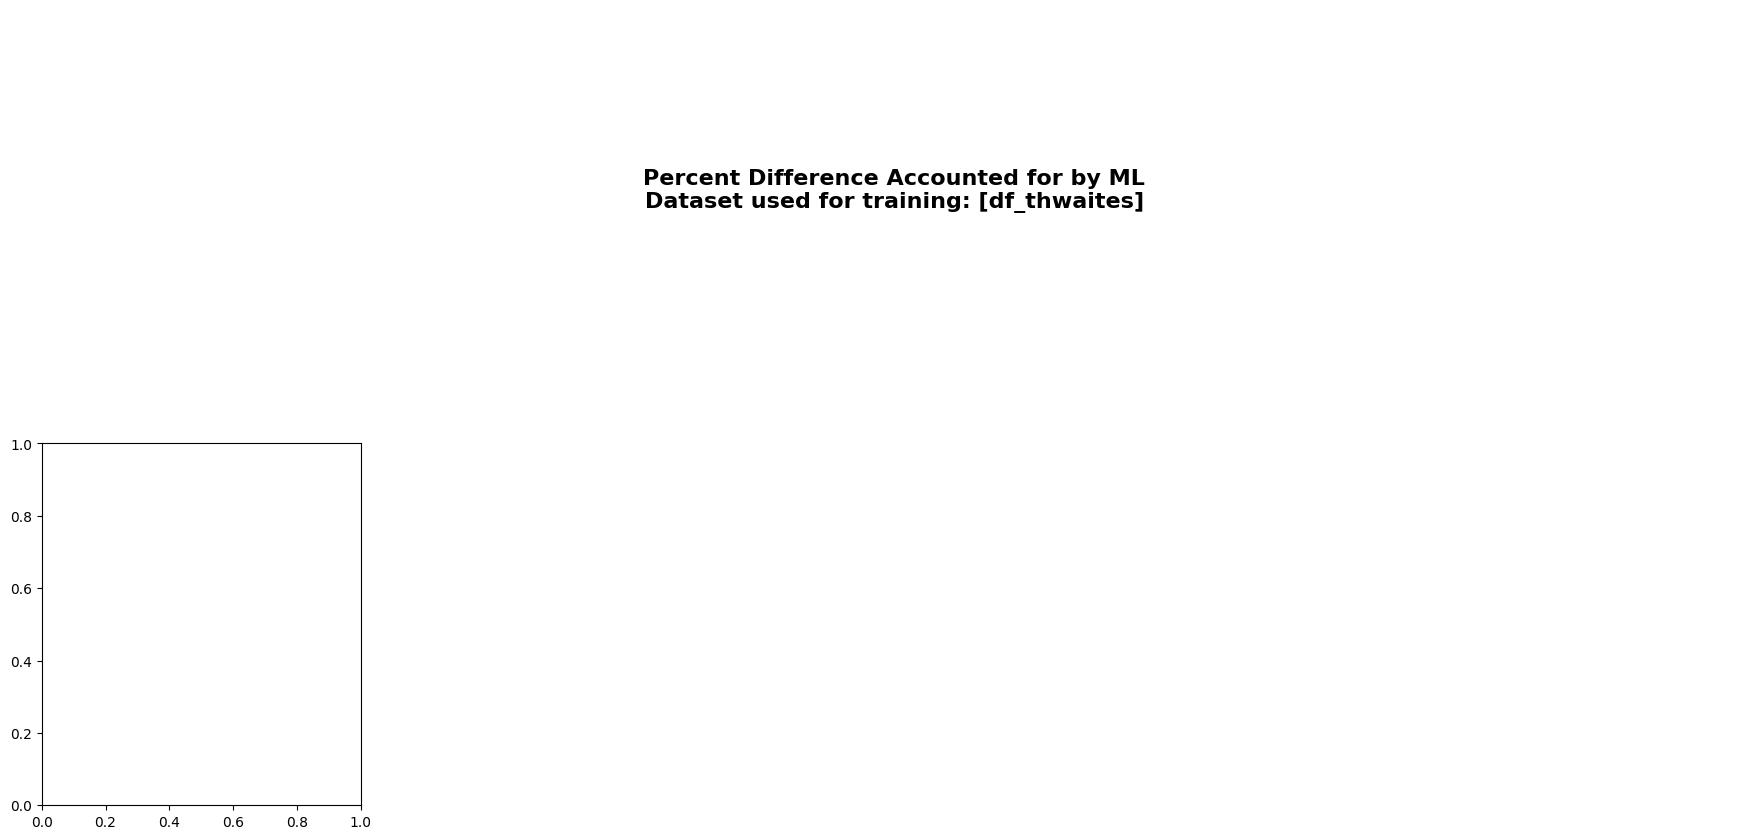

In [26]:
# Determine the dataset used based on select_dataset
if select_dataset == 0:
    dataset_used = "[df_dotson, df_dotson, df_thwaites]"
elif select_dataset == 1:
    dataset_used = "[df_pig, df_pig, df_thwaites]"
elif select_dataset == 2:
    dataset_used = "[df_dotson, df_pig]"
elif select_dataset == 3:
    dataset_used = "[df_dotson]"
elif select_dataset == 4:
    dataset_used = "[df_pig]"
elif select_dataset == 5:
    dataset_used = "[df_thwaites]"

# Since the lists have an equal number of objects, determine the number of rows
n_rows = len(temp_objects_dotson)

# Increase figure size to make the rows larger
fig = plt.figure(figsize=(22, 6 * n_rows))

# Create a gridspec layout with an extra row for the title
# Reduce hspace to decrease vertical gaps between rows
gs = gridspec.GridSpec(n_rows + 1, 5, width_ratios=[4, 4, 4, 4, 0.2], wspace=0.4, hspace=0.2)

# Add a new axes for the title with the dynamic dataset info
ax_title = fig.add_subplot(gs[0, :])
title_text = f"Percent Difference Accounted for by ML\nDataset used for training: {dataset_used}"
ax_title.text(0.5, 0.5, title_text, fontsize=16, weight='bold', ha='center', va='center')
ax_title.axis('off')  # Turn off the axis for the title

# Loop over the objects and plot in the corresponding grid positions
for row in range(n_rows):
    # Summary column (column 0)
    ax_summary = fig.add_subplot(gs[row + 1, 0])
    summary_text = (
        f"{columns_list_dotson[row]}\n"
        f"R2 test: {summary_list_dotson[row]['r2_mean']:.4f}\n"
        f"R2_adjusted test: {summary_list_dotson[row]['r2_adjusted_mean']:.4f}\n"
        f"MSE test: {summary_list_dotson[row]['mse_mean']:.4f}\n"
        f"% Loss function value dotson: {(loss_function_list_dotson[row]-inv_loss_dotson)/inv_loss_dotson:.4f}\n"
        f"% Loss function value pig: {(loss_function_list_pig[row]-inv_loss_pig)/inv_loss_pig:.4f}\n"
        f"% Loss function value thwaites: {(loss_function_list_thwaites[row]-inv_loss_thwaites)/inv_loss_thwaites:.4f}\n"
        f"% explained dotson: {return_percent_diff(temp_objects_dotson[row]):.4f}\n"
        f"% explained pig: {return_percent_diff(temp_objects_pig[row]):.4f}\n"
        f"% explained thwaites: {return_percent_diff(temp_objects_thwaites[rows]):.4f}\n"
        
    )
    ax_summary.text(0.1, 0.5, summary_text, fontsize=10, va="center", ha="left")
    ax_summary.axis('off')  # Turn off the axis for the text column
    
    # Dotson column (column 1)
    ax_dotson = fig.add_subplot(gs[row + 1, 1])
    _, ax_dotson = temp_objects_dotson[row].plot_percent_accounted(vmin=0, vmax = 100, axes=ax_dotson)
    if row == 0:
        ax_dotson.set_title("Dotson")
    
    # PIG column (column 2)
    ax_pig = fig.add_subplot(gs[row + 1, 2])
    _, ax_pig = temp_objects_pig[row].plot_percent_accounted(vmin=0, vmax = 100,  axes=ax_pig)
    if row == 0:
        ax_pig.set_title("PIG")
    
    # Thwaites column (column 3)
    ax_thwaites = fig.add_subplot(gs[row + 1, 3])
    _, ax_thwaites = temp_objects_thwaites[row].plot_percent_accounted(vmin=0, vmax = 100, axes=ax_thwaites)
    if row == 0:
        ax_thwaites.set_title("Thwaites")

    # Create a color bar at the end of the row (column 4)
    cax = fig.add_subplot(gs[row + 1, 4])
    fig.colorbar(ax_dotson.collections[0], cax=cax)

# Show the final figure
plt.show()
